In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
import torch
import librosa.display as lrdisplay
import librosa.feature as lrfeature
import glob
import functools
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics as skmetrics
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import ClassifierMixin, clone
from pathlib import PurePath

import vxs
import vxs.utils as vxsu

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



### Feature transformations

In [2]:
def mfcc_transform(sound):
    return vxs.mfcc(sound.cut_or_pad(4096), center=False).ravel()

def ramires_transform(sound):
    return vxs.ramires_features(sound.cut_or_pad(4096)).ravel()

def barkgram_transform_raw(sound, sound_len=65536):
    return vxs.bark_specgram(sound.cut_or_pad(sound_len), to_ternhardt_db=False)

def barkgram_cut_pad_db(S, pad_time=128, device='cpu'):
    if pad_time is not None:
        if S.shape[1] >= pad_time:
            S = S[:, :pad_time]
        else:
            S = np.pad(S, ((0, 0), (0, pad_time - S.shape[1])))
            
    S_db = vxs.to_ternhardt_db_scale(S) / 80.0
    return torch.tensor(S_db, device=device).float().unsqueeze(0)

def cae_features(S_db, model):
    return model.representation(S_db.unsqueeze(0)).detach().squeeze().cpu().numpy().ravel()

cae_model_types = list(vxs.CAE_CONFIGS.keys())
all_feat_types = ['mfcc'] + cae_model_types
def_pad_times = [8, 16, 24, 32, 64, 128]

def cae_feature_transform_ds(ds, model_types, pad_times=def_pad_times):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    caes = {}
    for mtype in model_types:
        model = vxs.get_CAE_model(mtype, f'../logs/cae-bark-finaldata_65536_{mtype}/checkpoints/best.pth').to(device)
        model.eval()
        caes[mtype] = model
    
    barkgrams = vxs.TransformDataset(ds, ft=barkgram_transform_raw)
    padded_dss = {}
    for pt in pad_times:
        feat_func = functools.partial(barkgram_cut_pad_db, pad_time=pt, device=device)
        padded_dss[pt] = vxs.TransformDataset(barkgrams, ft=feat_func)
        
    transformed_dss = {}
    for mtype, cae in caes.items():
        transformed_dss[mtype] = {}
        for pt, padded_ds in padded_dss.items():
            cae_func = functools.partial(cae_features, model=cae)
            transformed_dss[mtype][pt] = vxs.TransformDataset(padded_ds, ft=cae_func)
    
    return transformed_dss

def feature_transform_ds(ds, model_types, cae_pad_times=def_pad_times):
    classic_feats = [mt for mt in model_types if mt not in cae_model_types]
    cae_feats = [mt for mt in model_types if mt in cae_model_types]
    
    classic_dss = {}
    for ftype in classic_feats:
        if ftype == 'mfcc':
            feat_func = mfcc_transform
        elif ftype == 'ramires':
            feat_func = ramires_transform
        else:
            raise ValueError('unknown feature type '+ftype)
            
        classic_dss[ftype] = vxs.TransformDataset(ds, ft=feat_func)
    
    cae_dss = cae_feature_transform_ds(ds, cae_feats, cae_pad_times)
    return {**classic_dss, **cae_dss}

def apply_transforms(*dss, **kwargs):
    transform = functools.partial(feature_transform_ds, **kwargs)
    return (transform(ds) for ds in dss)

def append_path(path, segm):
    if path is None:
        return None
    elif path == '':
        return segm
    else:
        return path + '.' + str(segm)

def traverse_dict(dc, func, path=None):
    if type(dc) != dict:
        if path is None:
            return func(dc)
        return func(dc, path=path)
    else:
        return {
            key: traverse_dict(subdc, func, path=append_path(path, key))
            for key, subdc in dc.items()
        }
    
def zip_dicts(dc1, dc2):
    if type(dc1) != dict or type(dc2) != dict:
        return (dc1, dc2)
    else:
        common_keys = list(set(dc1.keys()).intersection(set(dc2.keys())))
        return {key: zip_dicts(dc1[key], dc2[key]) for key in common_keys}

def merge_dicts(dc1, dc2):
    if type(dc1) != dict:
        return dc1
    
    all_keys = list(set(dc1.keys()).union(set(dc2.keys())))
    res = {}
    for k in all_keys:
        sub1 = dc1.get(k, {})
        sub2 = dc2.get(k, {})
        if len(sub1) == 0:
            res[k] = sub2
        elif len(sub2) == 0:
            res[k] = sub1
        else:
            res[k] = merge_dicts(sub1, sub2)
    return res
    
def transform_split(ds, percentage, random_seed=None, **kwargs):
    train_ixs, test_ixs = vxs.stratified_split_ixs(ds, percentage, random_seed)
    transformed_dss = feature_transform_ds(ds, **kwargs)
    
    def _split(ds):
        return vxs.LazySubset(ds, train_ixs), vxs.LazySubset(ds, test_ixs)
    
    return traverse_dict(transformed_dss, _split)

In [3]:
avp_segments_fixed = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/fixed/*/*.wav'))
print(len(avp_segments_fixed))
avp_segments_personal = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/personal/*/*.wav'))
print(len(avp_segments_personal))
bbset1_segments = vxs.SimpleSampleSet(glob.glob('../data_temp/beatboxset1/DR/*/*.wav'))
print(len(bbset1_segments))
drums200 = vxs.SimpleSampleSet.from_csv('../data/200-drum-machines/annotation.csv')
print(len(drums200))

3317
2875
2317
1422


In [4]:
def make_knn(**kwargs):
    return vxs.prepend_normalizer(KNeighborsClassifier(**kwargs))

def make_ramires(**kwargs):
    return vxs.prepend_normalizer(vxs.RamiresClassifier(audio_transform=False, **kwargs))

def train_eval_model(train_test, model, path=None):
    train_data, test_data = train_test
    tqdm_name_train = None
    tqdm_name_test = None
    if path is not None:
        print('train/eval '+path)
        tqdm_name_train = 'extract train'
        tqdm_name_test = 'extract test'
        
    X_train, y_train = vxsu.unzip_dataset(train_data, tqdm_name=tqdm_name_train)
    X_test, y_test = vxsu.unzip_dataset(test_data, tqdm_name=tqdm_name_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if path is not None:
        print(f'accuracy: {skmetrics.accuracy_score(y_test, y_pred)}')
    return y_test, y_pred

def model_cross_val(data, model, k_folds=5, random_seed=42, path=None, balanced=False):
    tqdm_name = None
    if path is not None:
        print('cross-validate '+path)
        tqdm_name = 'extract data'
    
    X, y = vxsu.unzip_dataset(data, tqdm_name=tqdm_name)
    print(model)        
    if 'ramiresclassifier' in model.named_steps and isinstance(model.named_steps['ramiresclassifier'],
                                                               vxs.RamiresClassifier):
        model.fit(X, y)
        model.named_steps['ramiresclassifier'].set_sfs_fit(False)
    
    kfolder = StratifiedKFold(k_folds, shuffle=True, random_state=42)
    scoring = 'balanced_accuracy' if balanced else 'accuracy'
    return cross_val_score(model, X, y, scoring=scoring, cv=kfolder, n_jobs=-1)

def train_eval_all(dss, make_model_fn, verbose=True):
    path = '' if verbose else None
    return traverse_dict(dss, functools.partial(train_eval_model, model=model), path=path)

def model_cross_val_all(dss, model, verbose=True, k_folds=5, random_seed=42, balanced=False):
    path = '' if verbose else None
    return traverse_dict(dss, functools.partial(
        model_cross_val, model=model, k_folds=k_folds, random_seed=random_seed, balanced=balanced),
                         path=path)

### AVP Personal segments

In [5]:
avp_p_transformed = feature_transform_ds(avp_segments_personal, model_types=all_feat_types)
#avp_train_test_transformed = transform_split(avp_segments_personal, 0.2, random_seed=42, model_types=all_feat_types)

In [5]:
def train_eval_knn(dss, make_knn=make_knn, ks=[3, 5, 7, 10, 15],
                   ws=['uniform', 'distance'], verbose=True, **kwargs):
    knn_results = {}
    for k in ks:
        knn_results[k] = {}
        for w in ws:
            print(f'KNN {k} {w} training eval')
            knn = make_knn(n_neighbors=k, weights=w, **kwargs)
            knn_results[k][w] = train_eval_all(dss, knn, verbose=verbose)
    return knn_results

def cross_val_knn(dss, make_knn=make_knn, ks=[3, 5, 7, 10, 15], balanced=False,
                  ws=['distance'], verbose=True, **kwargs):
    knn_results = {}
    for k in ks:
        knn_results[k] = {}
        for w in ws:
            print(f'KNN {k} {w} cross-val')
            knn = make_knn(n_neighbors=k, weights=w, **kwargs)
            knn_results[k][w] = model_cross_val_all(dss, knn, balanced=balanced, verbose=verbose)
    return knn_results

In [14]:
avp_p_ramires = feature_transform_ds(avp_segments_personal, model_types=['ramires'])

In [19]:
%%time
avp_p_ramires_crossval = cross_val_knn(avp_p_ramires, make_ramires, cv=5)

extract data: 100%|██████████| 2875/2875 [00:00<00:00, 1011714.41it/s]

KNN 3 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   weights='distance'))])



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.5s finished

[2020-08-23 15:46:21] Features: 1/54 -- score: 0.4045217391304348[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.5s finished

[2020-08-23 15:46:22] Features: 2/54 -- score: 0.5582608695652175[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.5s finished

[2020-08-23 15:46:24] Features: 3/54 -- score: 0.6772173913043478[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

KNN 5 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   n_neighbors=5, weights='distance'))])



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.5s finished

[2020-08-23 15:52:53] Features: 1/54 -- score: 0.4121739130434783[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.5s finished

[2020-08-23 15:52:55] Features: 2/54 -- score: 0.5732173913043478[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.6s finished

[2020-08-23 15:52:57] Features: 3/54 -- score: 0.6803478260869567[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

KNN 7 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   n_neighbors=7, weights='distance'))])



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.6s finished

[2020-08-23 15:59:39] Features: 1/54 -- score: 0.4114782608695652[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.6s finished

[2020-08-23 15:59:40] Features: 2/54 -- score: 0.5833043478260869[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.7s finished

[2020-08-23 15:59:42] Features: 3/54 -- score: 0.6838260869565217[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

KNN 10 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   n_neighbors=10, weights='distance'))])



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.6s finished

[2020-08-23 16:06:48] Features: 1/54 -- score: 0.4156521739130435[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.7s finished

[2020-08-23 16:06:49] Features: 2/54 -- score: 0.5975652173913044[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.8s finished

[2020-08-23 16:06:51] Features: 3/54 -- score: 0.686608695652174[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

KNN 15 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   n_neighbors=15, weights='distance'))])



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.7s finished

[2020-08-23 16:14:24] Features: 1/54 -- score: 0.4236521739130435[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.8s finished

[2020-08-23 16:14:26] Features: 2/54 -- score: 0.5986086956521739[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.9s finished

[2020-08-23 16:14:28] Features: 3/54 -- score: 0.6831304347826087[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

CPU times: user 12min 43s, sys: 1.52 s, total: 12min 45s
Wall time: 35min 56s


In [21]:
avp_p_ramires_crossval

{3: {'distance': {'ramires': array([0.93913043, 0.93043478, 0.96521739, 0.9426087 , 0.94782609])}},
 5: {'distance': {'ramires': array([0.92869565, 0.90782609, 0.94782609, 0.92521739, 0.94434783])}},
 7: {'distance': {'ramires': array([0.92347826, 0.92      , 0.95478261, 0.92521739, 0.93565217])}},
 10: {'distance': {'ramires': array([0.91478261, 0.90782609, 0.93043478, 0.93217391, 0.92      ])}},
 15: {'distance': {'ramires': array([0.90086957, 0.89565217, 0.90434783, 0.88869565, 0.90782609])}}}

In [26]:
%%time
#knn_results_avp = train_eval_knn(avp_train_test_transformed, verbose=False)
#knn_results_avp = cross_val_knn(avp_p_transformed, verbose=False)
knn_results_avp = vxsu.load_pickle('../data_temp/knn_crossval_avp.pt')

CPU times: user 2.3 ms, sys: 267 µs, total: 2.56 ms
Wall time: 17.1 ms


In [27]:
knn_results_avp = merge_dicts(avp_p_ramires_crossval, knn_results_avp)

In [29]:
with open('../data_temp/knn_crossval_avp.pt', 'wb') as f:
    pickle.dump(knn_results_avp, f)

### AVP Fixed segments

In [30]:
avp_f_transformed = feature_transform_ds(avp_segments_fixed, model_types=all_feat_types)
#avp_f_train_test_transformed = transform_split(avp_segments_fixed, 0.2, random_seed=42, model_types=all_feat_types)

In [31]:
%%time
#knn_results_avp_f = train_eval_knn(avp_f_train_test_transformed, verbose=False)
#knn_results_avp_f = cross_val_knn(avp_f_transformed, verbose=False)
knn_results_avp_f = vxsu.load_pickle('../data_temp/knn_crossval_avp-fixed.pt')

CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.21 ms


In [32]:
avp_f_ramires = feature_transform_ds(avp_segments_fixed, model_types=['ramires'])

In [33]:
%%time
avp_f_ramires_crossval = cross_val_knn(avp_f_ramires, make_ramires, cv=5)

extract data:   0%|          | 5/3317 [00:00<01:18, 42.41it/s]

KNN 3 distance cross-val
cross-validate ramires


extract data: 100%|██████████| 3317/3317 [01:18<00:00, 42.30it/s]


Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   weights='distance'))])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.9s finished

[2020-08-23 16:27:39] Features: 1/54 -- score: 0.5667625252139781[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    0.8s finished

[2020-08-23 16:27:40] Features: 2/54 -- score: 0.7147985607588726[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    0.9s finished

[2020-08-23 16:27:41] Features: 3/54 -- score: 0.7796193825074051[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    0.9s finished

[2020-08-23 16:27:42] Features: 4/54 -- score: 0.8486616147849316[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(

KNN 5 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   n_neighbors=5, weights='distance'))])



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  54 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.1s finished

[2020-08-23 16:34:39] Features: 1/54 -- score: 0.5709821185193261[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.2s finished

[2020-08-23 16:34:40] Features: 2/54 -- score: 0.7368092278616729[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    1.2s finished

[2020-08-23 16:34:41] Features: 3/54 -- score: 0.7958962547020662[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.3s finished

[2020-08-23 16:34:42] Features: 4/54 -- score: 0.8522778898399025[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent

KNN 7 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   n_neighbors=7, weights='distance'))])



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.1s finished

[2020-08-23 16:42:06] Features: 1/54 -- score: 0.5718907303421832[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.1s finished

[2020-08-23 16:42:07] Features: 2/54 -- score: 0.7431399807374294[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    1.2s finished

[2020-08-23 16:42:08] Features: 3/54 -- score: 0.7995193443457087[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  51 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.3s finished

[2020-08-23 16:42:10] Features: 4/54 -- score: 0.8522765269221683[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent

KNN 10 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   n_neighbors=10, weights='distance'))])



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  54 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.2s finished

[2020-08-23 16:50:01] Features: 1/54 -- score: 0.5730978211488489[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.2s finished

[2020-08-23 16:50:02] Features: 2/54 -- score: 0.7503766196005742[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    1.3s finished

[2020-08-23 16:50:03] Features: 3/54 -- score: 0.8001172109251484[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  51 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.4s finished

[2020-08-23 16:50:04] Features: 4/54 -- score: 0.8

KNN 15 distance cross-val
cross-validate ramires
Pipeline(steps=[('normalizer', Normalizer()),
                ('ramiresclassifier',
                 RamiresClassifier(audio_transform=False,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                   n_neighbors=15, weights='distance'))])



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  54 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.2s finished

[2020-08-23 16:58:01] Features: 1/54 -- score: 0.5791260062875938[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.3s finished

[2020-08-23 16:58:02] Features: 2/54 -- score: 0.7506796416434971[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    1.3s finished

[2020-08-23 16:58:04] Features: 3/54 -- score: 0.8052440531356193[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  51 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.5s finished

[2020-08-23 16:58:05] Features: 4/54 -- score: 0.8

CPU times: user 4min 41s, sys: 2min 9s, total: 6min 51s
Wall time: 40min 48s


In [34]:
knn_results_avp_f = merge_dicts(avp_f_ramires_crossval, knn_results_avp_f)

In [35]:
with open('../data_temp/knn_crossval_avp-fixed.pt', 'wb') as f:
    pickle.dump(knn_results_avp_f, f)

### Classifying BBset1 segments using onlavp_segments_fixedized drums test data

In [16]:
drums200_tr = feature_transform_ds(drums200, model_types=all_feat_types)
bbset1_tr = feature_transform_ds(bbset1_segments, model_types=all_feat_types)
d200_bbs_train_test = zip_dicts(drums200_tr, bbset1_tr)

In [17]:
%%time
#knn_results_d200_bbset = train_eval_knn(d200_bbs_train_test, verbose=False)
knn_results_d200_bbset = vxsu.load_pickle('../data_temp/knn_results_d200_bbset.pt')

CPU times: user 23.1 ms, sys: 37 ms, total: 60 ms
Wall time: 59.3 ms


In [188]:
with open('../data_temp/knn_results_d200_bbset.pt', 'wb') as f:
    pickle.dump(knn_results_d200_bbset, f)

### Plots

In [6]:
def cls_reports(rss):
    return traverse_dict(rss, lambda p: skmetrics.classification_report(p[0], p[1], output_dict=True))

def crossval_scores_stats(rss):
    return traverse_dict(rss, lambda s: (np.mean(s), np.std(s, ddof=1)/np.sqrt(len(s)), np.min(s), np.max(s)))

def split_classic_caes(rss, depth=2):
    def _classics(dct):
        return {key: val for key, val in dct.items() if key not in cae_model_types}
    
    def _caes(dct):
        return {key: val for key, val in dct.items() if key in cae_model_types}
    
    classics = vxsu.apply_on_depth(rss, _classics, depth)
    caes = vxsu.apply_on_depth(rss, _caes, depth)
    return classics, caes

def split_cv_stats(dss):
    cvs = crossval_scores_stats(dss)
    classics, caes = split_classic_caes(cvs)
    classics = vxsu.MultilevelDict(classics, ['knn_k', 'knn_w', 'feat_type']).sub(knn_w='distance')
    caes = vxsu.MultilevelDict(caes, ['knn_k', 'knn_w', 'feat_type', 'pad_time']).sub(knn_w='distance')
    return classics, caes

In [78]:
cvs_avp_classics, cvs_avp_caes = split_cv_stats(knn_results_avp)

In [79]:
cvs_avp_f_classics, cvs_avp_f_caes = split_cv_stats(knn_results_avp_f)

In [7]:
def plot_with_bands(xs, ps, **kwargs):
    means = np.array([p[0] for p in ps])
    std = np.array([p[1] for p in ps])
    plt.plot(xs, means, **kwargs)
    plt.fill_between(xs, means - std, means + std, alpha=0.2)

In [81]:
cvs_caes_k3 = {
    'personal': cvs_avp_caes.sub(knn_k=3).sink('pad_time').dct,
    'fixed': cvs_avp_f_caes.sub(knn_k=3).sink('pad_time').dct,
}

In [8]:
cae_groups = {
    'square': ['square-1', 'square-2', 'square-3'],
    'tall': ['tall-1', 'tall-2', 'tall-3', 'tall-4'],
    'wide': ['wide-1', 'wide-2', 'wide-3', 'wide-4']
}

def plot_caes_padtimes(cvs_caes, fsize=20, figsize=(12, 7.5), save_name=None):

    fig, axess = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row', figsize=(12, 7.5))

    for subset, axes in zip(['personal', 'fixed'], axess):
        for (cae_group, cae_types), ax in zip(cae_groups.items(), axes):
            plt.sca(ax)
            for cae_type in cae_types:
                ps, accs = vxsu.unzip_dict_ordered(cvs_caes[subset][cae_type])
                xs = np.arange(len(ps))
                cae_family, cae_num = cae_type.split('-')

                plot_with_bands(xs, accs, label=cae_num, marker='o') #, ls=lss[cae_family])
                plt.xticks(ticks=xs, labels=ps, fontsize=fsize-4)

            if subset == 'personal':
                plt.title(cae_group, fontsize=fsize)
            if cae_group == 'square':
                plt.ylabel(f'Accuracy ({subset.capitalize()})', fontsize=fsize)
            plt.yticks(fontsize=fsize-4)
            #plt.ylim(ylims)
            #elif cae_group == 'wide':
            plt.legend(fontsize=fsize-2, ncol=2) #, loc='center left', bbox_to_anchor=(1, 0.5))
            if subset == 'fixed':
                plt.xlabel('Barkgram length', fontsize=fsize)
            plt.grid(which='both')

    fig.tight_layout()
    if save_name is not None:
        vxsu.save_plot(save_name)

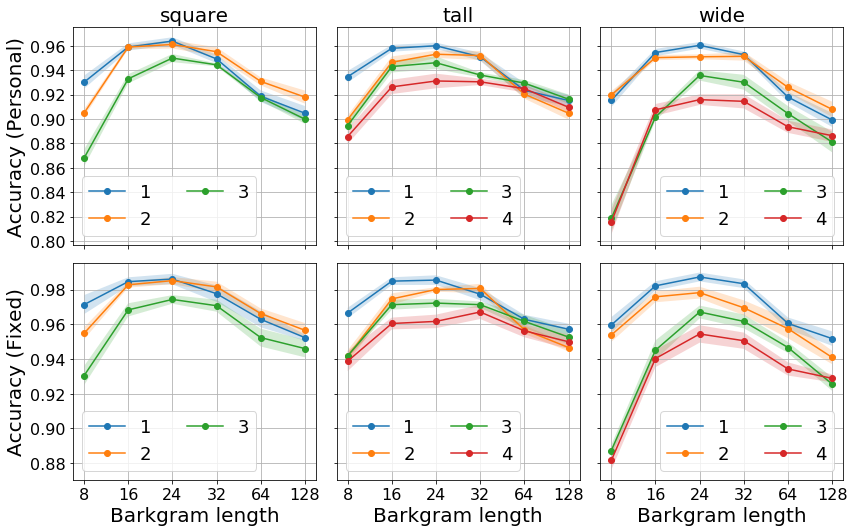

In [89]:
plot_caes_padtimes(cvs_caes_k3, save_name='caes_timeframes_accuracy')

In [84]:
caes_24 = {
    'personal': cvs_avp_caes.sub(pad_time=24).sink('knn_k').dct,
    'fixed': cvs_avp_f_caes.sub(pad_time=24).sink('knn_k').dct,
}
classics = {
    'personal': cvs_avp_classics.sink('knn_k').dct,
    'fixed': cvs_avp_f_classics.sink('knn_k').dct,
}

In [9]:
def plot_knn_ks(caes, classics, fsize=20, figsize=(12, 4.3), save_name=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 4.3))
    chosen_caes = ['square-1', 'tall-1', 'wide-1']

    for subset, ax in zip(['personal', 'fixed'], axes):
        plt.sca(ax)
        for feat in classics[subset].keys():
            ps, accs = vxsu.unzip_dict_ordered(classics[subset][feat])
            xs = np.arange(len(ps))
            label = 'MFCC' if feat == 'mfcc' else 'Ramires (+SFS)'
            plot_with_bands(xs, accs, label=label, marker='o')
            plt.xticks(ticks=xs, labels=ps, fontsize=fsize-4)

        for cae in chosen_caes:
            ps, accs = vxsu.unzip_dict_ordered(caes[subset][cae])
            xs = np.arange(len(ps))
            plot_with_bands(xs, accs, label=f'{cae} (24 fr.)', marker='o')
            plt.xticks(ticks=xs, labels=ps, fontsize=fsize-4)

        plt.title(f'AVP {subset.capitalize()}', fontsize=fsize)
        plt.yticks(fontsize=fsize-4)
        if subset == 'personal':
            plt.ylabel('Accuracy', fontsize=fsize)
        plt.xlabel('Num. of neighbors', fontsize=fsize)
        if subset == 'fixed':
            plt.legend(fontsize=fsize-2, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(which='both')

    fig.tight_layout()
    if save_name is not None:
        vxsu.save_plot(save_name)

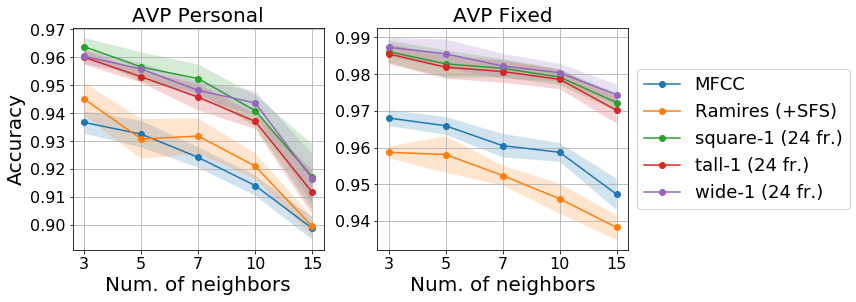

In [88]:
plot_knn_ks(caes_24, classics, save_name='caes_mfccs_crossval')

### Segmentation + classification

In [10]:
avp_fixed_improvs = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Fixed', recordings_type='improvs')
avp_personal_improvs = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Personal', recordings_type='improvs')
print(len(avp_fixed_improvs))
print(len(avp_personal_improvs))

28
25


In [11]:
def mk_cae_classifier(mtype, ckp_path):
    ckp_path = ckp_path.format(mtype)
    model = vxs.get_CAE_model(mtype, ckp_path)
    model.eval()
    return vxs.make_knn_cae(model.encoder, sgram_type='bark', frame_len=12288, n_neighbors=3, weights='distance')

In [12]:
cae_types = ['square-1', 'tall-1', 'wide-1']

nn_classifiers = {
    ('nn_'+mtype): vxs.CAEClassifier(mtype, '../logs/classifiers/classifier-next_{}_24_fine/checkpoints/best.pth')
    for mtype in cae_types
}

cae_knn_classifiers = {
    ('knn_'+mtype): mk_cae_classifier(mtype, '../logs/cae-bark-finaldata_65536_{}/checkpoints/best.pth')
    for mtype in cae_types
}

classics = {
    'mfcc': vxs.make_knn_classic('mfcc', n_neighbors=3, weights='distance'),
    'ramires': vxs.make_ramires_sfs(n_neighbors=3, weights='distance', cv=5, verbose=0)
}

classifiers = {**nn_classifiers, **cae_knn_classifiers, **classics}

In [21]:
def fit_classifiers(train_data, classifiers):
    for ctype, model in tqdm(classifiers.items()):
        print(ctype)
        if not ctype.startswith('nn_'):
            X, y = vxsu.unzip_dataset(train_data)
            model.fit(X, y)

def fit_classifiers_personalized(train_data, classifiers):
    pnames = np.unique([PurePath(t.filepath).parts[-2] for t, cl in train_data])
    personalized = {}
    for ctype, model in tqdm(classifiers.items()):
        if not ctype.startswith('nn_'):
            print(ctype)
            personalized[ctype] = {}
            for pname in pnames:
                #X, y = zip(*[(t, cl) for t, cl in train_data if PurePath(t.filepath).parts[-2] == pname])
                #print(pname, len(X))
                model_p = clone(model)
                #model_p.fit(X,y)
                personalized[ctype][pname] = model_p
            
    return personalized

In [301]:
fit_classifiers(avp_segments_fixed, classifiers)

  0%|          | 0/8 [00:00<?, ?it/s]

nn_square-1
nn_tall-1
nn_wide-1
knn_square-1


 50%|█████     | 4/8 [00:50<00:50, 12.70s/it]

knn_tall-1


 62%|██████▎   | 5/8 [01:42<01:12, 24.30s/it]

knn_wide-1


 75%|███████▌  | 6/8 [02:31<01:03, 31.91s/it]

mfcc


 88%|████████▊ | 7/8 [03:04<00:32, 32.07s/it]

ramires


100%|██████████| 8/8 [05:50<00:00, 43.87s/it]


In [14]:
lang_model = None #vxs.load_model_from_bundle('../data/drum_kit_rnn.mag')

In [15]:
def eval_all(classifiers, lang_model, tracks, save_dir_p, reuse_saved=True, model_selector=None):
    cfs = {}
    for mtype, model in classifiers.items():
        print(mtype, 'nolm')
        cfs[mtype] = {}
        nolm_cf, nolm_scores = vxs.segment_classify_all(tracks, model, personalized_model_selector=model_selector,
                                                        reuse_saved=reuse_saved, save_dir=save_dir_p.format('nolm', mtype))
        display.display(nolm_cf)
        display.display(nolm_scores)
        cfs[mtype]['nolm'] = nolm_cf

        print(mtype, 'lm')
        lm_cf, lm_scores = vxs.segment_classify_all(tracks, model, lang_model, personalized_model_selector=model_selector,
                                                    reuse_saved=reuse_saved, save_dir=save_dir_p.format('lm', mtype))
        display.display(lm_cf)
        display.display(lm_scores)
        cfs[mtype]['lm'] = lm_cf
    return cfs

def avp_model_selector(models, track):
    pname = 'participant_{}'.format(int(PurePath(track.filepath).stem.split('_')[0][1:]))
    return models[pname]

In [16]:
cfs_fixed = eval_all(classifiers, lang_model, avp_fixed_improvs,
                     '../logs/avp_fixed_transcription_backtrack/{}/{}')

Analysing tracks: 1it [00:00,  7.82it/s]

nn_square-1 nolm


Analysing tracks: 28it [00:03,  8.48it/s]


,hhc,hho,kd,sd,sil
hhc,210.0,26.0,6.0,41.0,25.0
hho,48.0,305.0,2.0,9.0,3.0
kd,8.0,2.0,475.0,12.0,49.0
sd,21.0,9.0,18.0,305.0,12.0
sil,15.0,12.0,48.0,33.0,0.0


,prec,rec,F1
hhc,0.695364,0.681818,0.688525
hho,0.861582,0.831063,0.846047
kd,0.865209,0.869963,0.86758
sd,0.7625,0.835616,0.797386
total,0.806854,0.81652,0.811658


Analysing tracks: 2it [00:00, 19.12it/s]

nn_square-1 lm


Analysing tracks: 28it [00:03,  8.84it/s]


,hhc,hho,kd,sd,sil
hhc,192.0,29.0,3.0,45.0,39.0
hho,41.0,300.0,2.0,6.0,17.0
kd,7.0,2.0,472.0,6.0,59.0
sd,24.0,8.0,20.0,284.0,29.0
sil,19.0,12.0,35.0,30.0,0.0


,prec,rec,F1
hhc,0.678445,0.623377,0.649746
hho,0.854701,0.819672,0.83682
kd,0.887218,0.864469,0.875696
sd,0.765499,0.778082,0.771739
total,0.811971,0.787382,0.799488


Analysing tracks: 2it [00:00, 16.99it/s]

nn_tall-1 nolm


Analysing tracks: 28it [00:03,  7.82it/s]


,hhc,hho,kd,sd,sil
hhc,220.0,24.0,7.0,32.0,25.0
hho,69.0,286.0,0.0,9.0,3.0
kd,13.0,7.0,466.0,11.0,49.0
sd,19.0,13.0,12.0,309.0,12.0
sil,16.0,16.0,48.0,28.0,0.0


,prec,rec,F1
hhc,0.652819,0.714286,0.682171
hho,0.82659,0.779292,0.802244
kd,0.874296,0.85348,0.863763
sd,0.794344,0.846575,0.819629
total,0.798131,0.807692,0.802883


Analysing tracks: 2it [00:00, 10.84it/s]

nn_tall-1 lm


Analysing tracks: 28it [00:03,  8.11it/s]


,hhc,hho,kd,sd,sil
hhc,220.0,17.0,2.0,30.0,39.0
hho,61.0,283.0,0.0,5.0,17.0
kd,9.0,0.0,470.0,8.0,59.0
sd,17.0,8.0,14.0,297.0,29.0
sil,12.0,21.0,40.0,23.0,0.0


,prec,rec,F1
hhc,0.689655,0.714286,0.701754
hho,0.860182,0.773224,0.814388
kd,0.893536,0.860806,0.876866
sd,0.818182,0.813699,0.815934
total,0.826285,0.801262,0.813581


Analysing tracks: 1it [00:00,  8.15it/s]

nn_wide-1 nolm


Analysing tracks: 28it [00:03,  7.53it/s]


,hhc,hho,kd,sd,sil
hhc,213.0,23.0,9.0,38.0,25.0
hho,43.0,310.0,0.0,10.0,3.0
kd,7.0,4.0,476.0,10.0,49.0
sd,10.0,6.0,23.0,314.0,12.0
sil,20.0,11.0,50.0,28.0,0.0


,prec,rec,F1
hhc,0.726962,0.691558,0.708819
hho,0.875706,0.846995,0.861111
kd,0.853047,0.871795,0.862319
sd,0.785,0.860274,0.820915
total,0.818069,0.828391,0.823197


Analysing tracks: 2it [00:00, 14.23it/s]

nn_wide-1 lm


Analysing tracks: 28it [00:02, 10.04it/s]


,hhc,hho,kd,sd,sil
hhc,210.0,17.0,6.0,36.0,39.0
hho,40.0,299.0,0.0,10.0,17.0
kd,4.0,6.0,470.0,7.0,59.0
sd,8.0,6.0,25.0,297.0,29.0
sil,11.0,18.0,38.0,29.0,0.0


,prec,rec,F1
hhc,0.769231,0.681818,0.722892
hho,0.864162,0.81694,0.839888
kd,0.871985,0.860806,0.866359
sd,0.783641,0.813699,0.798387
total,0.830189,0.805047,0.817425


Analysing tracks: 2it [00:00, 14.27it/s]

knn_square-1 nolm


Analysing tracks: 28it [00:02, 11.02it/s]


,hhc,hho,kd,sd,sil
hhc,206.0,50.0,6.0,21.0,25.0
hho,64.0,297.0,0.0,2.0,3.0
kd,6.0,3.0,468.0,20.0,49.0
sd,7.0,2.0,1.0,343.0,12.0
sil,16.0,40.0,39.0,14.0,0.0


,prec,rec,F1
hhc,0.688963,0.668831,0.678748
hho,0.757653,0.811475,0.783641
kd,0.910506,0.857143,0.883019
sd,0.8575,0.939726,0.896732
total,0.818692,0.829022,0.823824


Analysing tracks: 2it [00:00, 14.18it/s]

knn_square-1 lm


Analysing tracks: 28it [00:02, 11.54it/s]


,hhc,hho,kd,sd,sil
hhc,190.0,56.0,1.0,22.0,39.0
hho,73.0,276.0,0.0,0.0,17.0
kd,6.0,1.0,459.0,21.0,59.0
sd,5.0,2.0,3.0,326.0,29.0
sil,20.0,22.0,26.0,28.0,0.0


,prec,rec,F1
hhc,0.646259,0.616883,0.631229
hho,0.773109,0.754098,0.763485
kd,0.93865,0.840659,0.886957
sd,0.821159,0.893151,0.855643
total,0.813923,0.789274,0.801409


Analysing tracks: 2it [00:00, 14.88it/s]

knn_tall-1 nolm


Analysing tracks: 28it [00:02,  9.86it/s]


,hhc,hho,kd,sd,sil
hhc,182.0,59.0,10.0,33.0,25.0
hho,55.0,307.0,0.0,1.0,3.0
kd,9.0,3.0,472.0,13.0,49.0
sd,8.0,2.0,1.0,342.0,12.0
sil,12.0,40.0,37.0,19.0,0.0


,prec,rec,F1
hhc,0.684211,0.588997,0.633043
hho,0.746959,0.838798,0.790219
kd,0.907692,0.864469,0.885553
sd,0.838235,0.936986,0.884864
total,0.811838,0.821564,0.816672


Analysing tracks: 1it [00:00,  9.88it/s]

knn_tall-1 lm


Analysing tracks: 28it [00:02, 11.37it/s]


,hhc,hho,kd,sd,sil
hhc,175.0,61.0,7.0,26.0,39.0
hho,56.0,292.0,0.0,1.0,17.0
kd,8.0,4.0,466.0,9.0,59.0
sd,5.0,2.0,2.0,327.0,29.0
sil,17.0,25.0,30.0,24.0,0.0


,prec,rec,F1
hhc,0.670498,0.568182,0.615114
hho,0.760417,0.797814,0.778667
kd,0.922772,0.85348,0.886775
sd,0.844961,0.89589,0.869681
total,0.819779,0.794953,0.807175


Analysing tracks: 1it [00:00,  6.85it/s]

knn_wide-1 nolm


Analysing tracks: 28it [00:02, 10.29it/s]


,hhc,hho,kd,sd,sil
hhc,198.0,54.0,6.0,26.0,25.0
hho,64.0,297.0,0.0,2.0,3.0
kd,4.0,1.0,478.0,14.0,49.0
sd,5.0,2.0,3.0,343.0,12.0
sil,13.0,43.0,35.0,17.0,0.0


,prec,rec,F1
hhc,0.697183,0.640777,0.667791
hho,0.748111,0.811475,0.778506
kd,0.915709,0.875458,0.895131
sd,0.853234,0.939726,0.894394
total,0.819938,0.82976,0.82482


Analysing tracks: 2it [00:00, 13.97it/s]

knn_wide-1 lm


Analysing tracks: 28it [00:02, 11.60it/s]


,hhc,hho,kd,sd,sil
hhc,188.0,51.0,4.0,26.0,39.0
hho,67.0,281.0,0.0,1.0,17.0
kd,4.0,1.0,468.0,14.0,59.0
sd,6.0,1.0,6.0,323.0,29.0
sil,15.0,32.0,29.0,20.0,0.0


,prec,rec,F1
hhc,0.671429,0.61039,0.639456
hho,0.76776,0.76776,0.76776
kd,0.923077,0.857143,0.888889
sd,0.841146,0.884932,0.862483
total,0.819779,0.794953,0.807175


Analysing tracks: 2it [00:00, 11.28it/s]

mfcc nolm


Analysing tracks: 28it [00:02, 10.43it/s]


,hhc,hho,kd,sd,sil
hhc,221.0,33.0,4.0,25.0,25.0
hho,88.0,273.0,0.0,2.0,3.0
kd,6.0,3.0,456.0,32.0,49.0
sd,34.0,6.0,10.0,303.0,12.0
sil,11.0,35.0,47.0,16.0,0.0


,prec,rec,F1
hhc,0.613889,0.717532,0.661677
hho,0.78,0.745902,0.76257
kd,0.882012,0.835165,0.857949
sd,0.801587,0.830137,0.815612
total,0.780685,0.790536,0.78558


Analysing tracks: 2it [00:00, 12.12it/s]

mfcc lm


Analysing tracks: 28it [00:02, 10.75it/s]


,hhc,hho,kd,sd,sil
hhc,218.0,25.0,1.0,25.0,39.0
hho,97.0,252.0,0.0,0.0,17.0
kd,5.0,2.0,448.0,32.0,59.0
sd,31.0,5.0,10.0,290.0,29.0
sil,14.0,28.0,33.0,21.0,0.0


,prec,rec,F1
hhc,0.59726,0.707792,0.647845
hho,0.807692,0.688525,0.743363
kd,0.910569,0.820513,0.863198
sd,0.788043,0.794521,0.791269
total,0.785947,0.762145,0.773863


Analysing tracks: 2it [00:00, 13.67it/s]

ramires nolm


Analysing tracks: 28it [00:02, 10.93it/s]


,hhc,hho,kd,sd,sil
hhc,208.0,24.0,8.0,43.0,25.0
hho,70.0,288.0,0.0,5.0,3.0
kd,23.0,17.0,402.0,55.0,49.0
sd,23.0,4.0,7.0,319.0,12.0
sil,19.0,40.0,34.0,16.0,0.0


,prec,rec,F1
hhc,0.606414,0.675325,0.639017
hho,0.772118,0.786885,0.779432
kd,0.891353,0.736264,0.806419
sd,0.728311,0.873973,0.794521
total,0.758255,0.767823,0.763009


Analysing tracks: 2it [00:00, 17.05it/s]

ramires lm


Analysing tracks: 28it [00:02, 10.59it/s]


,hhc,hho,kd,sd,sil
hhc,212.0,20.0,3.0,34.0,39.0
hho,75.0,267.0,0.0,7.0,17.0
kd,22.0,14.0,386.0,65.0,59.0
sd,28.0,5.0,10.0,293.0,29.0
sil,15.0,31.0,25.0,25.0,0.0


,prec,rec,F1
hhc,0.602273,0.688312,0.642424
hho,0.792285,0.729508,0.759602
kd,0.910377,0.70696,0.795876
sd,0.691038,0.80274,0.742712
total,0.753416,0.730599,0.741832


In [22]:
classifiers_personalized_f = fit_classifiers_personalized(avp_segments_fixed, classifiers)

 50%|█████     | 4/8 [00:00<00:00, 39.47it/s]

knn_square-1
knn_tall-1


 75%|███████▌  | 6/8 [00:00<00:00, 20.16it/s]

knn_wide-1
mfcc
ramires


100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


In [102]:
ramires_features_avpf = {
    name: model.named_steps['classifier'].sfs.k_feature_idx_
    for name, model in classifiers_personalized_f['ramires'].items()
}

In [103]:
vxsu.save_pickle(ramires_features_avpf, 'ramires_feat_avpf.pt')

In [23]:
cfs_fixed_personalized = eval_all(classifiers_personalized_f, lang_model, avp_fixed_improvs,
                                  '../logs/avp_fixed_transcription_personalized_backtrack/{}/{}', 
                                  model_selector=avp_model_selector)

Analysing tracks: 2it [00:00, 12.32it/s]

knn_square-1 nolm


Analysing tracks: 28it [00:02, 11.49it/s]


,hhc,hho,kd,sd,sil
hhc,179.0,53.0,35.0,17.0,25.0
hho,70.0,283.0,0.0,10.0,3.0
kd,10.0,2.0,474.0,11.0,49.0
sd,20.0,3.0,1.0,329.0,12.0
sil,23.0,20.0,48.0,17.0,0.0


,prec,rec,F1
hhc,0.592715,0.579288,0.585925
hho,0.783934,0.773224,0.778542
kd,0.849462,0.868132,0.858696
sd,0.856771,0.90137,0.878505
total,0.788162,0.797604,0.792855


Analysing tracks: 2it [00:00, 14.24it/s]

knn_square-1 lm


Analysing tracks: 28it [00:02,  9.47it/s]


,hhc,hho,kd,sd,sil
hhc,178.0,48.0,29.0,14.0,39.0
hho,64.0,277.0,0.0,8.0,17.0
kd,11.0,1.0,466.0,9.0,59.0
sd,19.0,2.0,1.0,314.0,29.0
sil,19.0,24.0,39.0,14.0,0.0


,prec,rec,F1
hhc,0.611684,0.577922,0.594324
hho,0.786932,0.756831,0.771588
kd,0.871028,0.85348,0.862165
sd,0.874652,0.860274,0.867403
total,0.803513,0.77918,0.79116


Analysing tracks: 2it [00:00, 14.87it/s]

knn_tall-1 nolm


Analysing tracks: 28it [00:02, 10.80it/s]


,hhc,hho,kd,sd,sil
hhc,179.0,59.0,31.0,14.0,25.0
hho,68.0,285.0,0.0,10.0,3.0
kd,6.0,3.0,477.0,11.0,49.0
sd,12.0,3.0,4.0,334.0,12.0
sil,26.0,24.0,40.0,19.0,0.0


,prec,rec,F1
hhc,0.61512,0.581169,0.597663
hho,0.762032,0.778689,0.77027
kd,0.86413,0.873626,0.868852
sd,0.860825,0.915068,0.887118
total,0.794393,0.804416,0.799373


Analysing tracks: 2it [00:00, 12.35it/s]

knn_tall-1 lm


Analysing tracks: 28it [00:02, 10.83it/s]


,hhc,hho,kd,sd,sil
hhc,180.0,54.0,26.0,9.0,39.0
hho,62.0,277.0,0.0,10.0,17.0
kd,6.0,0.0,473.0,8.0,59.0
sd,9.0,1.0,1.0,325.0,29.0
sil,26.0,25.0,27.0,18.0,0.0


,prec,rec,F1
hhc,0.636042,0.584416,0.609137
hho,0.77591,0.756831,0.766252
kd,0.897533,0.8663,0.88164
sd,0.878378,0.890411,0.884354
total,0.816526,0.791798,0.803972


Analysing tracks: 2it [00:00, 13.55it/s]

knn_wide-1 nolm


Analysing tracks: 28it [00:02, 11.37it/s]


,hhc,hho,kd,sd,sil
hhc,177.0,58.0,29.0,20.0,25.0
hho,66.0,287.0,0.0,10.0,3.0
kd,5.0,2.0,479.0,11.0,49.0
sd,17.0,1.0,4.0,331.0,12.0
sil,20.0,23.0,49.0,16.0,0.0


,prec,rec,F1
hhc,0.621053,0.572816,0.59596
hho,0.773585,0.784153,0.778833
kd,0.853832,0.877289,0.865402
sd,0.853093,0.906849,0.87915
total,0.793769,0.803279,0.798496


Analysing tracks: 2it [00:00, 17.86it/s]

knn_wide-1 lm


Analysing tracks: 28it [00:02, 10.52it/s]


,hhc,hho,kd,sd,sil
hhc,176.0,53.0,22.0,18.0,39.0
hho,66.0,273.0,0.0,10.0,17.0
kd,5.0,1.0,470.0,11.0,59.0
sd,17.0,1.0,1.0,317.0,29.0
sil,19.0,25.0,35.0,17.0,0.0


,prec,rec,F1
hhc,0.621908,0.571429,0.595601
hho,0.773371,0.745902,0.759388
kd,0.890152,0.860806,0.875233
sd,0.849866,0.868493,0.859079
total,0.804164,0.779811,0.7918


Analysing tracks: 2it [00:00, 14.79it/s]

mfcc nolm


Analysing tracks: 28it [00:02, 10.64it/s]


,hhc,hho,kd,sd,sil
hhc,203.0,31.0,33.0,16.0,25.0
hho,90.0,271.0,0.0,2.0,3.0
kd,7.0,0.0,463.0,27.0,49.0
sd,47.0,11.0,12.0,283.0,12.0
sil,17.0,13.0,60.0,19.0,0.0


,prec,rec,F1
hhc,0.557692,0.659091,0.604167
hho,0.831288,0.740437,0.783237
kd,0.815141,0.847985,0.831239
sd,0.815562,0.775342,0.794944
total,0.760125,0.769716,0.76489


Analysing tracks: 2it [00:00, 14.74it/s]

mfcc lm


Analysing tracks: 28it [00:02, 10.51it/s]


,hhc,hho,kd,sd,sil
hhc,201.0,25.0,28.0,15.0,39.0
hho,89.0,258.0,0.0,2.0,17.0
kd,8.0,0.0,458.0,21.0,59.0
sd,43.0,13.0,11.0,269.0,29.0
sil,17.0,10.0,46.0,23.0,0.0


,prec,rec,F1
hhc,0.561453,0.652597,0.603604
hho,0.843137,0.704918,0.767857
kd,0.843462,0.838828,0.841139
sd,0.815152,0.736986,0.774101
total,0.771633,0.748265,0.759769


Analysing tracks: 2it [00:00, 13.66it/s]

ramires nolm


Analysing tracks: 28it [00:02, 10.53it/s]


,hhc,hho,kd,sd,sil
hhc,183.0,37.0,5.0,58.0,25.0
hho,84.0,274.0,1.0,5.0,3.0
kd,14.0,0.0,314.0,169.0,49.0
sd,61.0,19.0,13.0,260.0,12.0
sil,20.0,14.0,40.0,34.0,0.0


,prec,rec,F1
hhc,0.505525,0.594156,0.546269
hho,0.796512,0.746594,0.770745
kd,0.841823,0.575092,0.683351
sd,0.494297,0.712329,0.583614
total,0.642368,0.650063,0.646192


Analysing tracks: 1it [00:00,  8.20it/s]

ramires lm


Analysing tracks: 28it [00:02, 10.92it/s]


,hhc,hho,kd,sd,sil
hhc,183.0,31.0,5.0,50.0,39.0
hho,85.0,259.0,1.0,4.0,17.0
kd,27.0,2.0,316.0,142.0,59.0
sd,52.0,20.0,9.0,255.0,29.0
sil,22.0,10.0,31.0,33.0,0.0


,prec,rec,F1
hhc,0.495935,0.594156,0.54062
hho,0.804348,0.70765,0.752907
kd,0.872928,0.578755,0.696035
sd,0.52686,0.69863,0.600707
total,0.659076,0.639117,0.648943


In [105]:
fit_classifiers(avp_segments_personal, classifiers)

  0%|          | 0/8 [00:00<?, ?it/s]

nn_square-1
nn_tall-1
nn_wide-1
knn_square-1


 50%|█████     | 4/8 [00:45<00:45, 11.38s/it]

knn_tall-1


 62%|██████▎   | 5/8 [01:33<01:06, 22.21s/it]

knn_wide-1


 75%|███████▌  | 6/8 [02:15<00:56, 28.43s/it]

mfcc


 88%|████████▊ | 7/8 [02:44<00:28, 28.36s/it]

ramires


100%|██████████| 8/8 [04:56<00:00, 37.12s/it]


In [24]:
cfs_personal = eval_all(classifiers, lang_model, avp_personal_improvs,
                        '../logs/avp_personal_transcription_backtrack/{}/{}')

Analysing tracks: 1it [00:00,  7.36it/s]

nn_square-1 nolm


Analysing tracks: 25it [00:02, 10.02it/s]


,hhc,hho,kd,sd,sil
hhc,174.0,81.0,24.0,44.0,1.0
hho,39.0,101.0,3.0,30.0,1.0
kd,36.0,17.0,456.0,28.0,26.0
sd,47.0,104.0,17.0,205.0,3.0
sil,17.0,16.0,87.0,60.0,0.0


,prec,rec,F1
hhc,0.555911,0.537037,0.546311
hho,0.316614,0.58046,0.409736
kd,0.776831,0.809947,0.793043
sd,0.558583,0.545213,0.551817
total,0.590164,0.651357,0.619252


Analysing tracks: 2it [00:00, 16.13it/s]

nn_square-1 lm


Analysing tracks: 25it [00:02, 11.62it/s]


,hhc,hho,kd,sd,sil
hhc,164.0,67.0,24.0,41.0,28.0
hho,38.0,99.0,2.0,24.0,10.0
kd,35.0,21.0,445.0,22.0,40.0
sd,47.0,104.0,16.0,180.0,28.0
sil,29.0,30.0,69.0,38.0,0.0


,prec,rec,F1
hhc,0.523962,0.506173,0.514914
hho,0.308411,0.572254,0.40081
kd,0.80036,0.790409,0.795353
sd,0.590164,0.48,0.529412
total,0.59398,0.618815,0.606143


Analysing tracks: 2it [00:00, 16.23it/s]

nn_tall-1 nolm


Analysing tracks: 25it [00:02, 10.31it/s]


,hhc,hho,kd,sd,sil
hhc,196,67,25,35,1
hho,37,99,2,35,1
kd,41,12,456,28,26
sd,58,84,21,211,3
sil,28,15,97,39,0


,prec,rec,F1
hhc,0.544444,0.604938,0.573099
hho,0.357401,0.568966,0.439024
kd,0.758735,0.809947,0.783505
sd,0.606322,0.559682,0.582069
total,0.606557,0.668985,0.636243


Analysing tracks: 2it [00:00, 15.97it/s]

nn_tall-1 lm


Analysing tracks: 25it [00:02, 11.47it/s]


,hhc,hho,kd,sd,sil
hhc,183.0,57.0,23.0,33.0,28.0
hho,33.0,95.0,1.0,34.0,10.0
kd,35.0,16.0,440.0,32.0,40.0
sd,55.0,77.0,21.0,194.0,28.0
sil,18.0,33.0,82.0,33.0,0.0


,prec,rec,F1
hhc,0.564815,0.564815,0.564815
hho,0.341727,0.549133,0.421286
kd,0.776014,0.781528,0.778761
sd,0.595092,0.517333,0.553495
total,0.610033,0.63554,0.622526


Analysing tracks: 2it [00:00, 18.31it/s]

nn_wide-1 nolm


Analysing tracks: 25it [00:02, 10.17it/s]


,hhc,hho,kd,sd,sil
hhc,183,69,25,45,1
hho,23,104,4,42,1
kd,39,13,461,24,26
sd,57,93,15,209,3
sil,17,17,101,45,0


,prec,rec,F1
hhc,0.573668,0.566563,0.570093
hho,0.351351,0.597701,0.442553
kd,0.760726,0.818828,0.788708
sd,0.572603,0.554377,0.563342
total,0.603405,0.665971,0.633146


Analysing tracks: 2it [00:00, 14.73it/s]

nn_wide-1 lm


Analysing tracks: 25it [00:02, 10.43it/s]


,hhc,hho,kd,sd,sil
hhc,179.0,55.0,24.0,37.0,28.0
hho,26.0,92.0,2.0,43.0,10.0
kd,36.0,15.0,445.0,27.0,40.0
sd,50.0,92.0,17.0,188.0,28.0
sil,19.0,30.0,83.0,35.0,0.0


,prec,rec,F1
hhc,0.577419,0.55418,0.565561
hho,0.323944,0.531792,0.402626
kd,0.779335,0.790409,0.784832
sd,0.569697,0.501333,0.533333
total,0.604682,0.630404,0.617276


Analysing tracks: 2it [00:00, 11.43it/s]

knn_square-1 nolm


Analysing tracks: 25it [00:02, 11.11it/s]


,hhc,hho,kd,sd,sil
hhc,207,60,22,34,1
hho,40,103,7,23,1
kd,35,8,461,33,26
sd,56,83,24,209,3
sil,21,12,128,20,0


,prec,rec,F1
hhc,0.576602,0.638889,0.606149
hho,0.387218,0.591954,0.468182
kd,0.718069,0.818828,0.765145
sd,0.655172,0.557333,0.602305
total,0.617907,0.682451,0.648577


Analysing tracks: 2it [00:00, 16.30it/s]

knn_square-1 lm


Analysing tracks: 25it [00:02, 11.38it/s]


,hhc,hho,kd,sd,sil
hhc,201.0,47.0,24.0,23.0,28.0
hho,43.0,90.0,7.0,23.0,10.0
kd,21.0,7.0,470.0,25.0,40.0
sd,50.0,78.0,28.0,191.0,28.0
sil,26.0,11.0,95.0,35.0,0.0


,prec,rec,F1
hhc,0.589443,0.622291,0.605422
hho,0.386266,0.520231,0.44335
kd,0.753205,0.834813,0.791912
sd,0.643098,0.509333,0.568452
total,0.636789,0.663877,0.650051


Analysing tracks: 2it [00:00, 14.70it/s]

knn_tall-1 nolm


Analysing tracks: 25it [00:02,  9.89it/s]


,hhc,hho,kd,sd,sil
hhc,204,62,27,30,1
hho,32,106,8,26,1
kd,23,10,478,26,26
sd,55,82,24,211,3
sil,26,12,106,38,0


,prec,rec,F1
hhc,0.6,0.62963,0.614458
hho,0.389706,0.612717,0.476404
kd,0.74339,0.849023,0.792703
sd,0.637462,0.562667,0.597734
total,0.629887,0.696167,0.66137


Analysing tracks: 2it [00:00, 15.92it/s]

knn_tall-1 lm


Analysing tracks: 25it [00:02, 11.27it/s]


,hhc,hho,kd,sd,sil
hhc,195.0,47.0,27.0,26.0,28.0
hho,42.0,98.0,8.0,15.0,10.0
kd,18.0,14.0,466.0,25.0,40.0
sd,50.0,75.0,23.0,199.0,28.0
sil,35.0,16.0,77.0,39.0,0.0


,prec,rec,F1
hhc,0.573529,0.603715,0.588235
hho,0.392,0.566474,0.463357
kd,0.775374,0.827709,0.800687
sd,0.654605,0.530667,0.586156
total,0.640803,0.668061,0.654148


Analysing tracks: 2it [00:00, 15.12it/s]

knn_wide-1 nolm


Analysing tracks: 25it [00:02, 10.56it/s]


,hhc,hho,kd,sd,sil
hhc,201,57,24,41,1
hho,34,108,10,20,1
kd,27,13,460,37,26
sd,52,80,21,219,3
sil,16,12,125,29,0


,prec,rec,F1
hhc,0.609091,0.62037,0.614679
hho,0.4,0.624277,0.487585
kd,0.71875,0.817052,0.764755
sd,0.632948,0.584,0.60749
total,0.622951,0.688502,0.654088


Analysing tracks: 2it [00:00, 13.38it/s]

knn_wide-1 lm


Analysing tracks: 25it [00:02,  9.64it/s]


,hhc,hho,kd,sd,sil
hhc,194.0,42.0,24.0,36.0,28.0
hho,40.0,93.0,10.0,20.0,10.0
kd,21.0,8.0,457.0,37.0,40.0
sd,42.0,73.0,24.0,207.0,28.0
sil,29.0,17.0,77.0,44.0,0.0


,prec,rec,F1
hhc,0.595092,0.598765,0.596923
hho,0.399142,0.537572,0.458128
kd,0.771959,0.811723,0.791342
sd,0.601744,0.553476,0.576602
total,0.63612,0.66318,0.649368


Analysing tracks: 2it [00:00, 16.17it/s]

mfcc nolm


Analysing tracks: 25it [00:02, 11.37it/s]


,hhc,hho,kd,sd,sil
hhc,155,102,39,28,1
hho,46,92,10,24,1
kd,30,10,483,14,26
sd,63,90,29,192,3
sil,18,4,132,25,0


,prec,rec,F1
hhc,0.496795,0.476923,0.486656
hho,0.308725,0.531792,0.390658
kd,0.69697,0.857904,0.769108
sd,0.678445,0.509284,0.581818
total,0.581337,0.641168,0.609788


Analysing tracks: 2it [00:00, 14.78it/s]

mfcc lm


Analysing tracks: 25it [00:02,  9.99it/s]


,hhc,hho,kd,sd,sil
hhc,154.0,74.0,34.0,34.0,28.0
hho,36.0,91.0,15.0,21.0,10.0
kd,22.0,12.0,478.0,11.0,40.0
sd,58.0,91.0,26.0,172.0,28.0
sil,17.0,6.0,123.0,20.0,0.0


,prec,rec,F1
hhc,0.536585,0.475309,0.504092
hho,0.332117,0.526012,0.407159
kd,0.707101,0.849023,0.77159
sd,0.666667,0.458667,0.543444
total,0.598662,0.623693,0.610922


Analysing tracks: 2it [00:00, 15.33it/s]

ramires nolm


Analysing tracks: 25it [00:02, 11.57it/s]


,hhc,hho,kd,sd,sil
hhc,171,84,43,26,1
hho,37,104,14,17,1
kd,21,6,494,16,26
sd,61,96,35,182,3
sil,20,2,139,18,0


,prec,rec,F1
hhc,0.551613,0.526154,0.538583
hho,0.356164,0.601156,0.447312
kd,0.681379,0.877442,0.767081
sd,0.702703,0.482759,0.572327
total,0.599622,0.661335,0.628968


Analysing tracks: 3it [00:00, 15.36it/s]

ramires lm


Analysing tracks: 25it [00:02, 10.19it/s]


,hhc,hho,kd,sd,sil
hhc,177.0,63.0,42.0,14.0,28.0
hho,37.0,92.0,18.0,16.0,10.0
kd,15.0,7.0,491.0,10.0,40.0
sd,58.0,84.0,37.0,168.0,28.0
sil,18.0,0.0,130.0,18.0,0.0


,prec,rec,F1
hhc,0.580328,0.546296,0.562798
hho,0.373984,0.531792,0.439141
kd,0.683844,0.872114,0.766589
sd,0.743363,0.448,0.559068
total,0.620736,0.64669,0.633447


In [25]:
classifiers_personalized_p = fit_classifiers_personalized(avp_segments_personal, classifiers)

  0%|          | 0/8 [00:00<?, ?it/s]

knn_square-1
knn_tall-1


100%|██████████| 8/8 [00:00<00:00, 24.20it/s]

knn_wide-1
mfcc
ramires


In [26]:
cfs_personal_personalized = eval_all(classifiers_personalized_p, lang_model, avp_personal_improvs,
                                     '../logs/avp_personal_transcription_personalized_backtrack/{}/{}',
                                     model_selector=avp_model_selector)

Analysing tracks: 0it [00:00, ?it/s]

knn_square-1 nolm


Analysing tracks: 25it [00:01, 14.35it/s]


,hhc,hho,kd,sd,sil
hhc,222.0,64.0,8.0,28.0,1.0
hho,16.0,146.0,2.0,8.0,1.0
kd,32.0,34.0,463.0,8.0,26.0
sd,36.0,93.0,15.0,228.0,3.0
sil,42.0,42.0,84.0,15.0,0.0


,prec,rec,F1
hhc,0.637931,0.687307,0.661699
hho,0.385224,0.843931,0.528986
kd,0.809441,0.82238,0.815859
sd,0.794425,0.608,0.688822
total,0.667718,0.738494,0.701325


Analysing tracks: 2it [00:00, 17.70it/s]

knn_square-1 lm


Analysing tracks: 25it [00:01, 14.67it/s]


,hhc,hho,kd,sd,sil
hhc,194.0,70.0,8.0,23.0,28.0
hho,17.0,138.0,1.0,7.0,10.0
kd,29.0,25.0,460.0,9.0,40.0
sd,28.0,92.0,11.0,215.0,28.0
sil,38.0,50.0,58.0,22.0,0.0


,prec,rec,F1
hhc,0.633987,0.600619,0.616852
hho,0.368,0.797688,0.50365
kd,0.855019,0.817052,0.835604
sd,0.778986,0.574866,0.661538
total,0.673579,0.702722,0.687842


Analysing tracks: 3it [00:00, 17.01it/s]

knn_tall-1 nolm


Analysing tracks: 25it [00:01, 15.60it/s]


,hhc,hho,kd,sd,sil
hhc,223.0,63.0,7.0,29.0,1.0
hho,19.0,146.0,1.0,6.0,1.0
kd,41.0,21.0,464.0,11.0,26.0
sd,35.0,84.0,17.0,236.0,3.0
sil,54.0,44.0,63.0,22.0,0.0


,prec,rec,F1
hhc,0.599462,0.690402,0.641727
hho,0.407821,0.843931,0.549906
kd,0.84058,0.824156,0.832287
sd,0.776316,0.629333,0.69514
total,0.674023,0.745467,0.707947


Analysing tracks: 3it [00:00, 17.68it/s]

knn_tall-1 lm


Analysing tracks: 25it [00:01, 15.78it/s]


,hhc,hho,kd,sd,sil
hhc,206.0,59.0,9.0,21.0,28.0
hho,15.0,143.0,0.0,5.0,10.0
kd,34.0,24.0,456.0,9.0,40.0
sd,32.0,88.0,12.0,214.0,28.0
sil,44.0,49.0,50.0,25.0,0.0


,prec,rec,F1
hhc,0.622356,0.637771,0.629969
hho,0.393939,0.82659,0.533582
kd,0.865275,0.809947,0.836697
sd,0.781022,0.572193,0.660494
total,0.681605,0.711096,0.696038


Analysing tracks: 3it [00:00, 16.41it/s]

knn_wide-1 nolm


Analysing tracks: 25it [00:01, 14.93it/s]


,hhc,hho,kd,sd,sil
hhc,224.0,60.0,9.0,29.0,1.0
hho,19.0,147.0,2.0,4.0,1.0
kd,29.0,20.0,476.0,12.0,26.0
sd,24.0,85.0,19.0,244.0,3.0
sil,35.0,41.0,82.0,25.0,0.0


,prec,rec,F1
hhc,0.676737,0.693498,0.685015
hho,0.416431,0.849711,0.558935
kd,0.809524,0.845471,0.827107
sd,0.77707,0.650667,0.708273
total,0.687894,0.760809,0.722517


Analysing tracks: 3it [00:00, 17.68it/s]

knn_wide-1 lm


Analysing tracks: 25it [00:01, 15.52it/s]


,hhc,hho,kd,sd,sil
hhc,211.0,52.0,9.0,23.0,28.0
hho,20.0,139.0,1.0,3.0,10.0
kd,28.0,24.0,462.0,9.0,40.0
sd,21.0,91.0,14.0,220.0,28.0
sil,33.0,51.0,57.0,27.0,0.0


,prec,rec,F1
hhc,0.674121,0.653251,0.663522
hho,0.389356,0.803468,0.524528
kd,0.850829,0.820604,0.835443
sd,0.780142,0.588235,0.670732
total,0.690301,0.720167,0.704918


Analysing tracks: 3it [00:00, 16.94it/s]

mfcc nolm


Analysing tracks: 25it [00:01, 15.19it/s]


,hhc,hho,kd,sd,sil
hhc,193,89,20,21,1
hho,30,119,1,22,1
kd,10,13,507,7,26
sd,43,81,24,225,3
sil,25,28,101,27,0


,prec,rec,F1
hhc,0.641196,0.595679,0.6176
hho,0.360606,0.687861,0.473161
kd,0.776417,0.900533,0.833882
sd,0.745033,0.598404,0.663717
total,0.65826,0.727019,0.690933


Analysing tracks: 3it [00:00, 17.74it/s]

mfcc lm


Analysing tracks: 25it [00:01, 15.77it/s]


,hhc,hho,kd,sd,sil
hhc,191.0,71.0,21.0,13.0,28.0
hho,33.0,113.0,1.0,16.0,10.0
kd,10.0,10.0,497.0,6.0,40.0
sd,46.0,85.0,20.0,196.0,28.0
sil,20.0,20.0,96.0,30.0,0.0


,prec,rec,F1
hhc,0.636667,0.589506,0.612179
hho,0.377926,0.653179,0.478814
kd,0.782677,0.882771,0.829716
sd,0.750958,0.522667,0.616352
total,0.66689,0.694774,0.680546


Analysing tracks: 3it [00:00, 16.49it/s]

ramires nolm


Analysing tracks: 25it [00:01, 15.65it/s]


,hhc,hho,kd,sd,sil
hhc,196.0,88.0,12.0,27.0,1.0
hho,29.0,114.0,3.0,26.0,1.0
kd,24.0,21.0,457.0,35.0,26.0
sd,67.0,84.0,25.0,199.0,3.0
sil,42.0,27.0,83.0,27.0,0.0


,prec,rec,F1
hhc,0.547486,0.604938,0.57478
hho,0.341317,0.65896,0.449704
kd,0.787931,0.811723,0.79965
sd,0.633758,0.526455,0.575145
total,0.609079,0.671766,0.638889


Analysing tracks: 2it [00:00, 16.83it/s]

ramires lm


Analysing tracks: 25it [00:01, 14.48it/s]


,hhc,hho,kd,sd,sil
hhc,167.0,85.0,13.0,31.0,28.0
hho,31.0,108.0,3.0,21.0,10.0
kd,22.0,21.0,444.0,36.0,40.0
sd,58.0,84.0,23.0,181.0,28.0
sil,36.0,19.0,78.0,34.0,0.0


,prec,rec,F1
hhc,0.531847,0.515432,0.523511
hho,0.340694,0.624277,0.440816
kd,0.791444,0.788632,0.790036
sd,0.59736,0.483957,0.534712
total,0.602007,0.627615,0.614544


In [27]:
lm_map = {
    'lm': 'LM',
    'nolm': 'No LM',
}

name_map = {
    'nn_square-1': 'DNN (square-1)',
    'nn_tall-1': 'DNN (tall-1)',
    'nn_wide-1': 'DNN (wide-1)',
    'knn_square-1': 'kNN (square-1)',
    'knn_tall-1': 'kNN (tall-1)',
    'knn_wide-1': 'kNN (wide-1)',
    'mfcc': 'MFCCs',
    'ramires': 'Ramires+SFS',
}

mt_map = {
    'prec': 'Precision',
    'rec': 'Recall',
    'F1': 'F1',
}

def cfs_to_df(cfs, cfs_p):
    columns = ['name', 'lm', 'personalized', 'metric', 'class', 'score']

    df = pd.DataFrame(columns=columns)
    for name, dct in cfs.items():
        for lm, cf in dct.items():
            scores = vxs.cf_to_prec_rec_F1(cf)
            for mt in ['prec', 'rec', 'F1']:
                for cl in ['kd', 'sd', 'hhc', 'hho', 'total']:
                    df.loc[len(df)] = [name_map[name], lm_map[lm], False, mt_map[mt], cl, scores.loc[cl, mt]]
                    
    for name, dct in cfs_p.items():
        for lm, cf in dct.items():
            scores = vxs.cf_to_prec_rec_F1(cf)
            for mt in ['prec', 'rec', 'F1']:
                for cl in ['kd', 'sd', 'hhc', 'hho', 'total']:
                    df.loc[len(df)] = [name_map[name], lm_map[lm], True, mt_map[mt], cl, scores.loc[cl, mt]]
    return df
        

In [28]:
df_f = cfs_to_df(cfs_fixed, cfs_fixed_personalized)

In [29]:
import matplotlib as mpl

def plot_bars(df, cls='total', savename=None):
    sns.set('paper', style='whitegrid', font_scale=2,
            rc={'ytick.left': True, 'xtick.bottom': True})
#     sns.catplot(y='name', x='score', hue='lm',
#                 data=df, kind='bar', row='personalized', col='metric')
    fig, axess = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row',
                              gridspec_kw={'height_ratios': [8, 5]},
                              figsize=(12, 8))
    cls_df = df[df['class'] == cls]
    for psn, axes in zip([False, True], axess):
        sub = cls_df[(cls_df['metric'] == 'F1') & (cls_df['personalized']==psn)]
        best_F1 = sub['score'].argmax()
        best_name = sub.iloc[best_F1]['name']
        
        for mt, ax in zip(['prec', 'rec', 'F1'], axes):
            plt.sca(ax)
            ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            subdf = cls_df[cls_df['metric'] == mt_map[mt]]
            xlims = (subdf['score'].min() - 0.01, subdf['score'].max() + 0.01)

            subdf = subdf[subdf['personalized'] == psn]
            sns.barplot(y='name', x='score',  hue='lm', data=subdf)
                        
            if mt == 'prec':
                plt.ylabel('Personalized' if psn else 'Non-personalized')
                ticks, labels = plt.yticks()
                for l in labels:
                    if l.get_text() == best_name:
                        l.set_fontweight('bold')
                
            else:
                plt.ylabel(None)
          
            plt.legend().remove()
            if psn:
                plt.xlabel(mt_map[mt])
            else:
                plt.xlabel(None)
            plt.xlim(xlims)
            ax.grid(b=True, which='major', axis='x', linewidth=1.0)
            ax.grid(b=True, which='minor', axis='x', linewidth=0.5)

    fig.tight_layout()
    axess[0][1].legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.2)) 
    if savename is not None:
        vxsu.save_plot(savename)
    plt.show()

In [30]:
df_f = cfs_to_df(cfs_fixed, cfs_fixed_personalized)

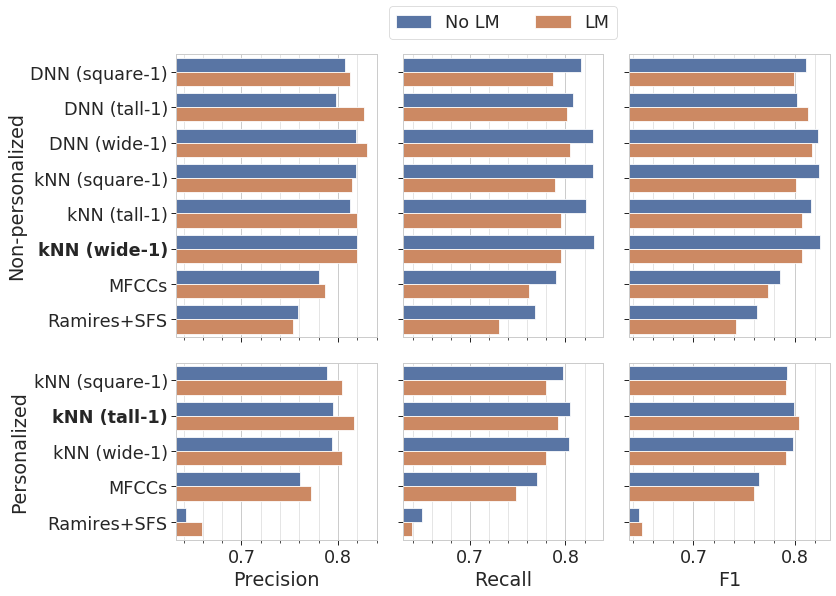

In [31]:
plot_bars(df_f, savename='avp_fixed_transcription_total')

In [32]:
df_p = cfs_to_df(cfs_personal, cfs_personal_personalized)

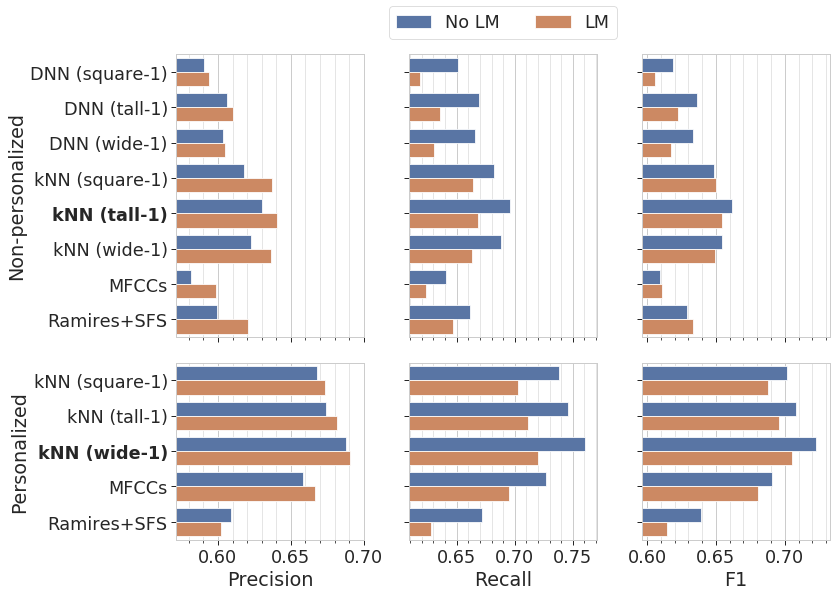

In [33]:
plot_bars(df_p, savename='avp_personal_transcription_total')

In [34]:
cfs_fixed['knn_wide-1']['nolm'].astype(int)

,hhc,hho,kd,sd,sil
hhc,198,54,6,26,25
hho,64,297,0,2,3
kd,4,1,478,14,49
sd,5,2,3,343,12
sil,13,43,35,17,0


In [35]:
cfs_fixed['knn_wide-1']['nolm'].astype(int).loc['hhc',:]

hhc    198
hho     54
kd       6
sd      26
sil     25
Name: hhc, dtype: int64

In [49]:
def print_confusion_matrix(confusion_matrix, class_names=None, figsize = (6,4), ax=None, fontsize=16, cbar=True,
                           savename=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if not isinstance(confusion_matrix, pd.DataFrame):
        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names, columns=class_names, 
        )
    else:
        df_cm = confusion_matrix
        
    if ax is not None:
        plt.sca(ax)
    else:
        fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=cbar)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if savename is not None:
        vxsu.save_plot(savename)

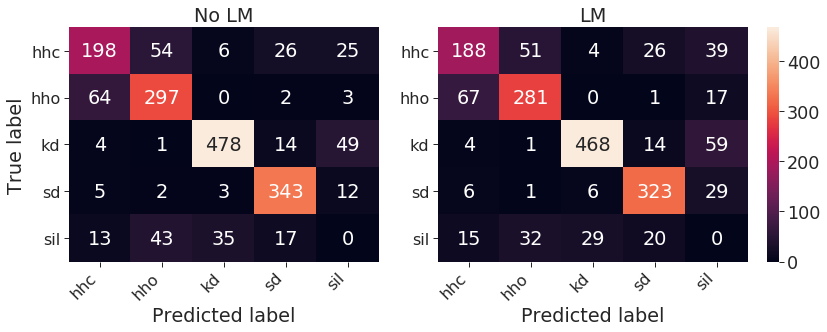

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [4, 5]})
print_confusion_matrix(cfs_fixed['knn_wide-1']['nolm'].astype(int), cbar=False, ax=axes[0])
plt.title('No LM')
print_confusion_matrix(cfs_fixed['knn_wide-1']['lm'].astype(int), ax=axes[1])
plt.title('LM')
plt.ylabel(None)
fig.tight_layout()
vxsu.save_plot('cf_knnwide')

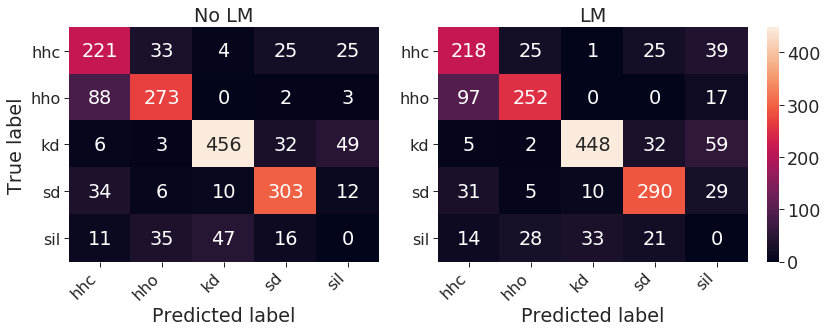

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [4, 5]})
print_confusion_matrix(cfs_fixed['mfcc']['nolm'].astype(int), cbar=False, ax=axes[0])
plt.title('No LM')
print_confusion_matrix(cfs_fixed['mfcc']['lm'].astype(int), ax=axes[1])
plt.title('LM')
plt.ylabel(None)
fig.tight_layout()
vxsu.save_plot('cf_mfcc')